#FAIKR module 3 project

#Simeoni Ildebrando 0001051567

##Introduction

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.

Heart failure in particluar is a common event caused by CVDs; it is a chronic, progressive condition in which the heart muscle is unable to pump enough blood to meet the body’s needs for blood and oxygen.
Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.
People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyponatremia or already established disease) need early detection and management.

The proposed work addresses this compelling problem with an application of a Bayesian Network for medical diagnosis and prediction which has its main advantage in its explainability and readability.
In particular, both causes and effects of cardiovascluar problems are take into consideration in the Network, in order to be able to prevent and detect those situations in high risk population, given factors such as: gender, age, unhealthy habits and relevant levels of chemical elements in human blood.

The report is organized as follows: 
1. a brief descrpition of the dataset used and the data manipulation process done
2. a detailed view of the Bayesian Network (with emphasis on both the analysis of its structure and the parameter learning process)
3. examples of inferences on the network (with particluar emphasis on the number of different methods used to address the inference process)
4. a narrow view on some highly relevant queries and conclusion thoughts related

In [ ]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 4.5 MB/s 


##Dataset

In this first section an overview of the dataset and the data manipulation processes related is shown.

The dataset used is a Kaggle dataset for heart failure prediction. 
With an high number of upvotes, the presence of a reasonal number of highly correlated attributes, the enormous magnitude of the problem and a high usability score given by Kaggle users, this dataset was preferred among a variety of others related to medical diagnosis and prediction.
On the other hand this dataset isn't immune to some of the problems that affect a lot of Kaggle datasets which are: the imbalance between some binary classes (e.g. in this case the gender is highly polarized towards women patients for example) and the lack of an high number of positive values for the desired attribute (in this case the heart failure attribute).

Given the simple structure of the Bayesian Network it wasn't considered necessary to upsample the dataset given, in order to retrive more accurate informations about relationships between nodes.

The dataset is composed of 13 attributes: 
1. age
2. anaemia: condition in which the number of red blood cells or the haemoglobin concentration within them is lower than normal (boolean)
3. creatinine_phosphokinase: level of the CPK enzyme in the blood (mcg/L)
4. diabetes: group of metabolic disorders characterized by a high blood sugar level over a prolonged period of time (boolean)
5. ejection_fraction: percentage of blood leaving the heart at each contraction (percentage)	
6. high_blood_pressure: medically defined as hypertension (boolean)	
7. platelets: number of platelets in the blood (kiloplatelets/mL)
8. serum_creatinine: level of serum creatinine in the blood (mg/dL)
9. serum_sodium: level of serum sodium in the blood (mEq/L)
10. sex: male 0, female 1 (boolean)	
11. smoking (boolean)
12. time: follow-up period (days)
13. DEATH_EVENT: if the patient deceased because of an heart failure during the follow-up period (boolean)

In [ ]:
from pandas import read_csv
import pandas as pd
import numpy as np

df_raw = read_csv("/content/drive/MyDrive/Magistrale/First year/Second semester/Faikr/Module 3/Project/heart_failure_clinical_records_dataset.csv")
df_raw.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


###Data cleaning

Among the 13 attributes only 11 have been considered relevant to the work. 
Being this a "time to event dataset", the attribute time was not relevant to the aim of the network, as explained here: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data/discussion/178372.

On the other hand, after researches, the serum creatinine levels in the blood  (given the CPK and sodium levels) weren't much relevant with respect to the other attributes of the dataset, so both these attributes have been eliminated from the dataframe.

For more precision and understandability both sex and DEATH_EVENT columns have been renamed, in particular emphasising that the death event was caused by an heart failure (at any time of his/her life given the fact that we removed the time attribute from the dataset).

In [ ]:
df=df_raw.drop(columns=['time','serum_creatinine'])
df.rename(
    columns=({ 'DEATH_EVENT': 'heart_failure', 'sex': 'gender'}), 
    inplace=True,
)


###Data discretization

Data needed to be discretized because Pgmpy doesn't support learning parameters from continuous variables (https://github.com/pgmpy/pgmpy/issues/1084).
In particular only relevant bins were taken into consideration.

In [ ]:
#Printing the min and max values of age in order to better discretize the age parameter
print(np.min(df['age']), np.max(df['age']))

40.0 95.0


In [ ]:
df['age']=pd.cut(x=df_raw['age'], bins=[np.min(df['age']),50,60,70,80,np.max(df['age'])], 
                        labels=["40-50","50-60", "60-70", "70-80", "80+"])

In [ ]:
df['creatinine_phosphokinase']=pd.cut(x=df_raw['creatinine_phosphokinase'], bins=[np.min(df['creatinine_phosphokinase']),350,600,np.max(df['creatinine_phosphokinase'])], 
                        labels=["normal level", "high level", "severely high level"])

In [ ]:
df['ejection_fraction']=pd.cut(x=df_raw['ejection_fraction'], bins=[np.min(df['ejection_fraction']),20,30,55,70,np.max(df['ejection_fraction'])], 
                        labels=["severe level","relatively severe level", "mildly low level", "normal level", "mildly high level"])

In [ ]:
df['platelets']=pd.cut(x=df_raw['platelets'], bins=[np.min(df['platelets']),150000,450000,np.max(df['platelets'])], 
                        labels=["thrombocytopenia", "normal level", "thrombocytosis"])


In [ ]:
df['serum_sodium']=pd.cut(x=df_raw['serum_sodium'], bins=[np.min(df['serum_sodium']),126,130,135,145,np.max(df['serum_sodium'])], 
                        labels=["severe hyponatremia", "moderate hyponatremia", "mild hyponatremia", "normonatremia", "hypernatremia"])

###Comparison

A final comparison between the raw and the refined dataframe that will be later used for parameter learning is here shown

In [ ]:
df_raw.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_sodium,gender,smoking,heart_failure
0,70-80,0,high level,0,severe level,1,normal level,moderate hyponatremia,1,0,1
1,50-60,0,severely high level,0,mildly low level,0,normal level,normonatremia,1,0,1
2,60-70,0,normal level,0,severe level,0,normal level,moderate hyponatremia,1,1,1
3,40-50,1,normal level,0,severe level,0,normal level,normonatremia,1,0,1
4,60-70,1,normal level,1,severe level,0,normal level,severe hyponatremia,0,0,1


##Network

In this chapter both the structure of the network, created from scratch by analyzing scientific papers related to the topic, and the parameter learning process are taken into account.

In particular, a variety of methods related to the analysis of Bayesian Networks are explored.

###Showing the network

A graphical preliminary overview of the network is shown using the visual library of pgmpy, the acronyms related to dataset attributes are the followings:
1. age: Age
2. anaemia: Ana
3. creatinine_phosphokinase: CPK
4. diabetes: Dia
5. ejection_fraction: Eje
6. high_blood_pressure: Blo	
7. platelets: Pla
8. serum_sodium: Sod
9. gender: Gen	
10. smoking: Smo
11. heart_failure: Fai




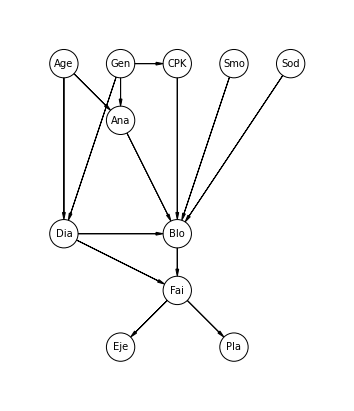

In [ ]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM(shape=[6, 7])

pgm.add_node(daft.Node('Gen', r"Gen", 2, 6))
pgm.add_node(daft.Node('Age', r"Age", 1, 6))
pgm.add_node(daft.Node('CPK', r"CPK", 3, 6))
pgm.add_node(daft.Node('Smo', r"Smo", 4, 6))
pgm.add_node(daft.Node('Sod', r"Sod", 5, 6))


pgm.add_node(daft.Node('Ana', r"Ana", 2, 5))

pgm.add_node(daft.Node('Dia', r"Dia", 1, 3))
pgm.add_node(daft.Node('Blo', r"Blo", 3, 3))

pgm.add_node(daft.Node('Fai', r"Fai", 3, 2))

pgm.add_node(daft.Node('Eje', r"Eje", 2, 1))
pgm.add_node(daft.Node('Pla', r"Pla", 4, 1))

pgm.add_edge('Gen', 'CPK')
pgm.add_edge('Gen', 'Dia')
pgm.add_edge('Age', 'Dia')
pgm.add_edge('Age', 'Ana')
pgm.add_edge('Gen', 'Ana')
pgm.add_edge('Dia', 'Blo')
pgm.add_edge('CPK', 'Blo')
pgm.add_edge('Ana', 'Blo')
pgm.add_edge('Smo', 'Blo')
pgm.add_edge('Sod', 'Blo')
pgm.add_edge('Blo', 'Fai')
pgm.add_edge('Dia', 'Fai')
pgm.add_edge('Fai', 'Eje')
pgm.add_edge('Fai', 'Pla')

pgm.render()
plt.show()

Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

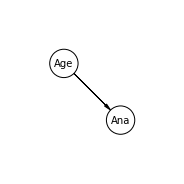

In [ ]:
# DIRECT CAUSE
pgm = PGM(shape=[3, 3])
pgm.add_node(daft.Node('Age', r"Age", 1, 2))
pgm.add_node(daft.Node('Ana', r"Ana", 2, 1))
pgm.add_edge('Age', 'Ana')
pgm.render()
plt.show()

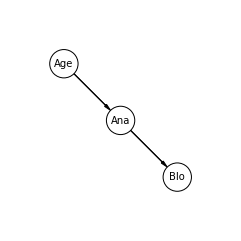

In [ ]:
# CAUSAL TRAIL
pgm = PGM(shape=[4, 4])
pgm.add_node(daft.Node('Age', r"Age", 1, 3))
pgm.add_node(daft.Node('Ana', r"Ana", 2, 2))
pgm.add_node(daft.Node('Blo', r"Blo", 3, 1))
pgm.add_edge('Age', 'Ana')
pgm.add_edge('Ana', 'Blo')
pgm.render()
plt.show()

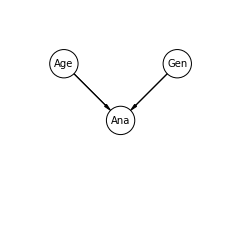

In [ ]:
# COMMON EFFECT
pgm = PGM(shape=[4, 4])
pgm.add_node(daft.Node('Age', r"Age", 1, 3))
pgm.add_node(daft.Node('Ana', r"Ana", 2, 2))
pgm.add_node(daft.Node('Gen', r"Gen", 3, 3))
pgm.add_edge('Age', 'Ana')
pgm.add_edge('Gen', 'Ana')
pgm.render()
plt.show()


###Creating the network 

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links in the medical field particularly challenging to model (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:

*   CPK -> high blood pressure

  Higher CPK activity increases cardiovascular
  trophic responses and development of arterial hypertension.
  Hence, high CPK activity may increase hypertension risk.
  https://www.jcdr.net/articles/PDF/12284/36908_CE[Ra1]_F(SL)_PF1(A_SHU).pdf
*   anaemia -> high blood pressure

  Anaemia is associated with higher cardiovascular risk, higher blood pressure values, and lower dipping status in hypertensive patients, and hemoglobin should be monitored in hypertensive patients.
  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4331396/
*   sodium -> high blood pressure

  The close relationship between hypertension and dietary sodium intake is widely recognized and supported by several studies. A reduction in dietary sodium not only decreases the blood pressure and the incidence of hypertension, but is also associated with a reduction in morbidity and mortality from cardiovascular diseases.  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6770596/

*   heart failure -> ejection fraction

  Ejection fraction (EF) is a measurement, expressed as a percentage, of how much blood the left ventricle pumps out with each contraction. 
  This indication of how well your heart is pumping out blood can help to diagnose and track heart failure.
  https://www.heart.org/en/health-topics/heart-failure/diagnosing-heart-failure/ejection-fraction-heart-failure-measurement


*   heart failure -> platelets

  Heart failure is associated with increased risk of venous thromboembolism, stroke, and sudden death. Platelet abnormalities have been well described in heart failure but the significance of platelets in contributing to the thromboembolic complications of heart failure remains uncertain.
  https://pubmed.ncbi.nlm.nih.gov/17028108/



In [ ]:
from pgmpy.models import BayesianModel

model = BayesianModel([('age', 'diabetes'),   ('age', 'anaemia'),   ('gender', 'diabetes'), ('gender', 'anaemia'), ('gender', 'creatinine_phosphokinase'),
                       ('anaemia', 'high_blood_pressure'),   ('diabetes', 'high_blood_pressure'), ('creatinine_phosphokinase', 'high_blood_pressure'),
                       ('smoking', 'high_blood_pressure'), ('serum_sodium', 'high_blood_pressure'),
                       ('diabetes', 'heart_failure'), ('high_blood_pressure', 'heart_failure'),
                       ('heart_failure', 'ejection_fraction'), ('heart_failure', 'platelets')])

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [ ]:
# Showing all the nodes of the model
model.nodes()

NodeView(('age', 'diabetes', 'anaemia', 'gender', 'creatinine_phosphokinase', 'high_blood_pressure', 'smoking', 'serum_sodium', 'heart_failure', 'ejection_fraction', 'platelets'))

In [ ]:
# Showing all the edges of the model
model.edges()

OutEdgeView([('age', 'diabetes'), ('age', 'anaemia'), ('diabetes', 'high_blood_pressure'), ('diabetes', 'heart_failure'), ('anaemia', 'high_blood_pressure'), ('gender', 'diabetes'), ('gender', 'anaemia'), ('gender', 'creatinine_phosphokinase'), ('creatinine_phosphokinase', 'high_blood_pressure'), ('high_blood_pressure', 'heart_failure'), ('smoking', 'high_blood_pressure'), ('serum_sodium', 'high_blood_pressure'), ('heart_failure', 'ejection_fraction'), ('heart_failure', 'platelets')])

In [ ]:
# Local independecies of a signle node, namely "high_blood_pressure".
# In this simplification of a real case structure gender and age don't influence directly hypertension given their influence on other factors such as anaemia, diabetes and chemicals
model.local_independencies("high_blood_pressure")

(high_blood_pressure ⟂ gender, age | anaemia, creatinine_phosphokinase, smoking, serum_sodium, diabetes)

In [ ]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any X ∈ X and Y ∈ Y given Z

print(model.is_dconnected("high_blood_pressure", "creatinine_phosphokinase"))
print(model.is_dconnected("serum_sodium", "diabetes",observed=["anaemia"] ))

True
False


In [ ]:
# Function is_irrelevant made from scratch by the definition of irrelevance given during the course 

def is_irrelevant (node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("The node {0} is not irrelevant with resepect to {1}, given the evidence {2}.".format(node1, node2, evidence))
  else:
    print("The node {0} is irrelevant with resepect to {1}, given the evidence {2}".format(node1, node2, evidence))


is_irrelevant("ejection_fraction", "diabetes", "heart_failure")


The node ejection_fraction is irrelevant with resepect to diabetes, given the evidence heart_failure


/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


In [ ]:
# Checking active trails from high blood pressure given the evidence diabetes
model.active_trail_nodes('high_blood_pressure', observed='diabetes')

{'high_blood_pressure': {'age',
  'anaemia',
  'creatinine_phosphokinase',
  'ejection_fraction',
  'gender',
  'heart_failure',
  'high_blood_pressure',
  'platelets',
  'serum_sodium',
  'smoking'}}

In [ ]:
# Checking the markov blanket of the node heart failure
model.get_markov_blanket("heart_failure")

['ejection_fraction', 'diabetes', 'high_blood_pressure', 'platelets']

###Parameter learning

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [ ]:
from pgmpy.estimators import BayesianEstimator

model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CPT of age:
+------------+-----------+
| age(40-50) | 0.228669  |
+------------+-----------+
| age(50-60) | 0.300341  |
+------------+-----------+
| age(60-70) | 0.290102  |
+------------+-----------+
| age(70-80) | 0.119454  |
+------------+-----------+
| age(80+)   | 0.0614334 |
+------------+-----------+ 

CPT of diabetes:
+-------------+--------------------+-----+---------------------+-----------+
| age         | age(40-50)         | ... | age(80+)            | age(80+)  |
+-------------+--------------------+-----+---------------------+-----------+
| gender      | gender(0)          | ... | gender(0)           | gender(1) |
+-------------+--------------------+-----+---------------------+-----------+
| diabetes(0) | 0.3813559322033898 | ... | 0.7727272727272727  | 0.74      |
+-------------+--------------------+-----+---------------------+-----------+
| diabetes(1) | 0.6186440677966102 | ... | 0.22727272727272727 | 0.26      |
+-------------+--------------------+-----+--------------

In [ ]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

True

In [ ]:
#Cardinality of all model nodes
model.get_cardinality()

defaultdict(int,
            {'age': 5,
             'anaemia': 2,
             'creatinine_phosphokinase': 3,
             'diabetes': 2,
             'ejection_fraction': 5,
             'gender': 2,
             'heart_failure': 2,
             'high_blood_pressure': 2,
             'platelets': 3,
             'serum_sodium': 5,
             'smoking': 2})

##Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.


###Exact Inference

Exact Inference in pgmpy is implemented through the Variable Elimination Method and Belief Propagation rather than with simple enumeration; being one of the purpouses of this work exploring topics seen in class, the former is choosen.


In [ ]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [ ]:
#Causal inference (prediction) will he/she have an heart failure given his smoking habit but not having anaemia?
print(infer.query(["heart_failure"],evidence={"anaemia": 0, "smoking": 1}))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6740 |
+------------------+----------------------+
| heart_failure(1) |               0.3260 |
+------------------+----------------------+


In [ ]:
#Evidential inference (explaination) explaining the prob of diabetes given that he had an heart failure
print(infer.query(["diabetes"],evidence={"heart_failure": 1}))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+-------------+-----------------+
| diabetes    |   phi(diabetes) |
+=============+=================+
| diabetes(0) |          0.5722 |
+-------------+-----------------+
| diabetes(1) |          0.4278 |
+-------------+-----------------+


In [ ]:
#Intercausal inference (explaining away) why he had an heart failure given the fact that he didn't have diabetes?
print(infer.query(["high_blood_pressure"],evidence={"heart_failure": 1, "diabetes": 0}))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+------------------------+----------------------------+
| high_blood_pressure    |   phi(high_blood_pressure) |
+========================+============================+
| high_blood_pressure(0) |                     0.5747 |
+------------------------+----------------------------+
| high_blood_pressure(1) |                     0.4253 |
+------------------------+----------------------------+


In [ ]:
#Inferences using hard evidence
print(infer.query(["heart_failure"],evidence={"high_blood_pressure": 0, "diabetes": 0}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6958 |
+------------------+----------------------+
| heart_failure(1) |               0.3042 |
+------------------+----------------------+


The maximum a posteriori (MAP) queries boil down to finding the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variables), given observations of some evidence variables. This is sometimes also referred to as partial abductive inference.

The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [ ]:
#Infer MAP queries
print(infer.map_query(["anaemia"]))
print(infer.map_query(["anaemia"], evidence={'gender': 0}))
print(infer.map_query(["anaemia"], evidence={'gender': 0, 'age': "80+"}))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'anaemia': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'anaemia': 0}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'anaemia': 1}


In the case of large models, or models in which variables have a lot of states, exact inference can be quite slow. Some of the ways to deal with that are:

1.   Try a different elimination order (or customize one)
2.   Using approximate inference using sampling algorithms

Even though the model taken into consideration doesn't require speed up for inference, for further information both these methods are explored.



Pgmpy allows changing the elimination ordering by choosing different heuristic functions in order to assign the cost to each node, namely:


1.   MinFill: the cost of a eliminating a node is the number of edges that need to be added (fill in edges) to the graph due to its elimination.
2.   MinNeighbors: the cost of a eliminating a node is the number of neighbors it has in the current graph.
3.   MinWeight: the cost of a eliminating a node is the product of weights, domain cardinality, of its neighbors.
4.   WeightedMinFill: the cost of eliminating a node is the sum of weights of the edges that need to be added to the graph due to its elimination, where a weight of an edge is the product of the weights, domain cardinality, of its constituent vertices.



In [ ]:
#Elimination ordering
print(infer._get_elimination_order(variables=["heart_failure"],
                                        evidence={"high_blood_pressure": 0, "diabetes": 0},
                                        elimination_order="MinFill"))

print(infer._get_elimination_order(variables=["heart_failure"],
                                        evidence={"high_blood_pressure": 0, "diabetes": 0},
                                        elimination_order="MinNeighbors"))

print(infer._get_elimination_order(variables=["heart_failure"],
                                        evidence={"high_blood_pressure": 0, "diabetes": 0},
                                        elimination_order="MinWeight"))

print(infer._get_elimination_order(variables=["heart_failure"],
                                        evidence={"high_blood_pressure": 0, "diabetes": 0},
                                        elimination_order="WeightedMinFill"))

  0%|          | 0/8 [00:00<?, ?it/s]

['ejection_fraction', 'serum_sodium', 'anaemia', 'age', 'creatinine_phosphokinase', 'gender', 'smoking', 'platelets']


  0%|          | 0/8 [00:00<?, ?it/s]

['ejection_fraction', 'platelets', 'age', 'gender', 'serum_sodium', 'anaemia', 'creatinine_phosphokinase', 'smoking']


  0%|          | 0/8 [00:00<?, ?it/s]

['ejection_fraction', 'platelets', 'age', 'gender', 'serum_sodium', 'creatinine_phosphokinase', 'anaemia', 'smoking']


  0%|          | 0/8 [00:00<?, ?it/s]

['ejection_fraction', 'platelets', 'age', 'gender', 'serum_sodium', 'creatinine_phosphokinase', 'anaemia', 'smoking']


In [ ]:
#Confronting times with differents elimination ordering
import time

orders=["MinFill","MinNeighbors","MinWeight","WeightedMinFill"]
for ord in orders:
  start_time = time.time()
  print(infer.query(variables=["heart_failure"],
                          evidence={"high_blood_pressure": 0, "diabetes": 0},
                          elimination_order=ord,
                          show_progress=True))
  print('--- Elimination order: {} ---'.format(ord))
  print(f'--- Query executed in {time.time() - start_time:0,.4f} seconds ---\n')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6958 |
+------------------+----------------------+
| heart_failure(1) |               0.3042 |
+------------------+----------------------+
--- Elimination order: MinFill ---
--- Query executed in 0.3667 seconds ---



0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6958 |
+------------------+----------------------+
| heart_failure(1) |               0.3042 |
+------------------+----------------------+
--- Elimination order: MinNeighbors ---
--- Query executed in 0.4651 seconds ---



0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6958 |
+------------------+----------------------+
| heart_failure(1) |               0.3042 |
+------------------+----------------------+
--- Elimination order: MinWeight ---
--- Query executed in 0.3631 seconds ---



0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6958 |
+------------------+----------------------+
| heart_failure(1) |               0.3042 |
+------------------+----------------------+
--- Elimination order: WeightedMinFill ---
--- Query executed in 0.3276 seconds ---



###Approximate Inference

Approximate Inference in pgmpy is implemented with a number of different sampling methods, in particular in this section the main focus is on the ones seen during the course.

In [ ]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [ ]:
# Sampling from an empty network
print(infer.query(variables=["heart_failure"], n_samples=100)) 

  0%|          | 0/11 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.5600 |
+------------------+----------------------+
| heart_failure(1) |               0.4400 |
+------------------+----------------------+


/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


In [ ]:
# Showing the convergence increasing number of samples
print(infer.query(variables=["heart_failure"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["heart_failure"], n_samples=10000)) #approximate probability with an high number of samples

print(VariableElimination(model).query(["heart_failure"]))      #true probability

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.7000 |
+------------------+----------------------+
| heart_failure(1) |               0.3000 |
+------------------+----------------------+


  0%|          | 0/11 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6656 |
+------------------+----------------------+
| heart_failure(1) |               0.3344 |
+------------------+----------------------+


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6706 |
+------------------+----------------------+
| heart_failure(1) |               0.3294 |
+------------------+----------------------+


In [ ]:
# Showing the results of a sampling process
print(inference.likelihood_weighted_sample( size=5)) #size = number of samples

  0%|          | 0/11 [00:00<?, ?it/s]

     age  diabetes  anaemia  gender creatinine_phosphokinase  \
0  70-80         0        0       1             normal level   
1  60-70         1        0       0             normal level   
2  70-80         1        1       1               high level   
3  60-70         1        0       1             normal level   
4  50-60         1        1       1               high level   

   high_blood_pressure  smoking       serum_sodium  heart_failure  \
0                    0        0      normonatremia              0   
1                    1        0      normonatremia              1   
2                    0        0      normonatremia              0   
3                    1        0      normonatremia              0   
4                    1        0  mild hyponatremia              0   

         ejection_fraction     platelets  _weight  
0         mildly low level  normal level      1.0  
1  relatively severe level  normal level      1.0  
2  relatively severe level  normal level    

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


 The get_distribution method computes distribution of variables from given data samples.

In [ ]:
# Likelihood sampling
print(infer.get_distribution(inference.likelihood_weighted_sample( size=100), ["heart_failure"], joint=True))

  0%|          | 0/11 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.7100 |
+------------------+----------------------+
| heart_failure(1) |               0.2900 |
+------------------+----------------------+


/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


In [ ]:
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample( size=100), ["heart_failure"]))

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6300 |
+------------------+----------------------+
| heart_failure(1) |               0.3700 |
+------------------+----------------------+


In [ ]:
# Gibbs sampling
from pgmpy.sampling import GibbsSampling
gibbs = GibbsSampling(model)
print(infer.get_distribution(gibbs.sample(size=100), ["heart_failure"] ))

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:531: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


  0%|          | 0/99 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6600 |
+------------------+----------------------+
| heart_failure(1) |               0.3400 |
+------------------+----------------------+


As we can see, given the same number of samples, the three methods for approximate inference outputs not so sligthly different results.

##Conclusions

In this last section the main focus shifts from exploring the network and its methods, focusing on some example of real interesting applications to the given dataset.

All the important queries here shown are then briefly interpreted and discussed.

The major focus will be in investigating causes and effects of heart failures events, and related probabilities, for this reason a first general probability of having an heart failure (given our dataset) without assuming any evidence is shown and discussed

In [ ]:
df["heart_failure"].value_counts()

0    203
1     96
Name: heart_failure, dtype: int64

In [ ]:
infer = VariableElimination(model)
print(infer.query(["heart_failure"]))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6706 |
+------------------+----------------------+
| heart_failure(1) |               0.3294 |
+------------------+----------------------+


As its shown our dataset, and consequently our model, is slightly unbalanced towards the probability of not having an heart failure, being this a problem of the majority of the dataset as previously discussed, the aim here is not to correct this unbalancement but rather look at this first unbiased probability as a benchmark for the successives queries.

###Query 1: heart failures and platelets

In [ ]:
for pla in (list(df["platelets"].value_counts().index)):
  print("Probability of an heart failure occurred given the level of platelets:",pla)
  print(infer.query(["heart_failure"], evidence={"platelets":pla}))

Probability of an heart failure occurred given the level of platelets: normal level


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6842 |
+------------------+----------------------+
| heart_failure(1) |               0.3158 |
+------------------+----------------------+
Probability of an heart failure occurred given the level of platelets: thrombocytopenia


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.5872 |
+------------------+----------------------+
| heart_failure(1) |               0.4128 |
+------------------+----------------------+
Probability of an heart failure occurred given the level of platelets: thrombocytosis


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6022 |
+------------------+----------------------+
| heart_failure(1) |               0.3978 |
+------------------+----------------------+


In this first query an important problem was taken into account, namely the still uncertain relationship between platelet abnormalities and heart failures.

Being this far away from a formal proof of the link between the two, it still enforces the belief that those are strictly related; in particular we can infer that the number of patients victims of an heart failure who had a normal level of platelets is very similar to the benchmark probability of our dataset, on the other hand significantly higher probabilities occurred when patients reported platelets abnormalities. In particular there is an evident 28% increase of the probability of having had an haeart failure given a thrombocytopenia (i.e. a condition in which the platelet count is under the normal level) and a 22% increase given a thrombocytosis (i.e. a condition in which there are an excessive number of platelets in the blood).

###Query 2: non controllable factors impact

In [ ]:
for gen in (list(df["gender"].value_counts().index)):
    print("Probability of an heart failure given gender {} ".format(gen))
    print(infer.query(["heart_failure"], evidence={"gender":gen}))

Probability of an heart failure given gender 1 


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6710 |
+------------------+----------------------+
| heart_failure(1) |               0.3290 |
+------------------+----------------------+
Probability of an heart failure given gender 0 


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6700 |
+------------------+----------------------+
| heart_failure(1) |               0.3300 |
+------------------+----------------------+


In [ ]:
for age in (list(df["age"].value_counts().index)):
  print("Probability of an heart failure given the age of the patient:",age)
  print(infer.query(["heart_failure"], evidence={"age":age}))

Probability of an heart failure given the age of the patient: 50-60


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6705 |
+------------------+----------------------+
| heart_failure(1) |               0.3295 |
+------------------+----------------------+
Probability of an heart failure given the age of the patient: 60-70


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6704 |
+------------------+----------------------+
| heart_failure(1) |               0.3296 |
+------------------+----------------------+
Probability of an heart failure given the age of the patient: 40-50


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6705 |
+------------------+----------------------+
| heart_failure(1) |               0.3295 |
+------------------+----------------------+
Probability of an heart failure given the age of the patient: 70-80


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6712 |
+------------------+----------------------+
| heart_failure(1) |               0.3288 |
+------------------+----------------------+
Probability of an heart failure given the age of the patient: 80+


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6714 |
+------------------+----------------------+
| heart_failure(1) |               0.3286 |
+------------------+----------------------+


In this second query the impact of non controllable factors over the probability of heart failures has been analyzed, in particular age and gender attributes are taken into consideration.

As we can see non controllable factors alone without any related disease or condition sligthly influence the probability of suffering from an heart failure which is near the dataset benchmark.

###Query 3: major impact factors

In [ ]:
print(infer.query(["heart_failure"], evidence={"high_blood_pressure": 0, "diabetes":0}))
print(infer.query(["heart_failure"], evidence={"high_blood_pressure": 1, "diabetes":1}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6958 |
+------------------+----------------------+
| heart_failure(1) |               0.3042 |
+------------------+----------------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.6017 |
+------------------+----------------------+
| heart_failure(1) |               0.3983 |
+------------------+----------------------+


Given the Bayesian Network structure developed in this work, the two most important factors that influence the probability of developing an heart failure are diabetes and high blood pressure, in particular in the previous cell this impact has been quantified.

The joint presence of both these conditions determines a 33% probability increase of experiencing an heart failure with respect to the absence of both.

###Query 4: best attribute for heart failure diagnosis

In [ ]:
for eje in (list(df["ejection_fraction"].value_counts().index)):
    print("Probability of an heart failure occurred given ejection fraction {} ".format(eje))
    print(infer.query(["heart_failure"], evidence={"ejection_fraction":eje}))

Probability of an heart failure occurred given ejection fraction mildly low level 


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.7685 |
+------------------+----------------------+
| heart_failure(1) |               0.2315 |
+------------------+----------------------+
Probability of an heart failure occurred given ejection fraction relatively severe level 


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.5500 |
+------------------+----------------------+
| heart_failure(1) |               0.4500 |
+------------------+----------------------+
Probability of an heart failure occurred given ejection fraction normal level 


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.7916 |
+------------------+----------------------+
| heart_failure(1) |               0.2084 |
+------------------+----------------------+
Probability of an heart failure occurred given ejection fraction severe level 


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.1522 |
+------------------+----------------------+
| heart_failure(1) |               0.8478 |
+------------------+----------------------+
Probability of an heart failure occurred given ejection fraction mildly high level 


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

+------------------+----------------------+
| heart_failure    |   phi(heart_failure) |
+==================+======================+
| heart_failure(0) |               0.7500 |
+------------------+----------------------+
| heart_failure(1) |               0.2500 |
+------------------+----------------------+


As can be easily seen in this last cell the most important attribute to look at in order to diagnose the probability of an heart failure is the ejection fraction, in particular increasingly high levels denote an exponential increase in the probability of heart failure.